# Loading Data

In [473]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("loan_data2017.csv", header=0)

C:\Users\Turiya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,112,123,124,125,128,129,130,133,134,136,139,140,141,142,143,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432750 entries, 0 to 432749
Columns: 145 entries, id to settlement_term
dtypes: float64(51), int64(51), object(43)
memory usage: 478.7+ MB


In [475]:
df.dtypes

id                                             object
member_id                                     float64
loan_amnt                                       int64
funded_amnt                                     int64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

# Loan Status _(Target Variable)_

Loan Status is our target Variable. Another reason for looking into this variable is to reduce the size of the Data Set.

In [476]:
df.loan_status.value_counts()

Current               374892
Fully Paid             39992
Late (31-120 days)      6396
Charged Off             5861
In Grace Period         4007
Late (16-30 days)       1592
Default                   10
Name: loan_status, dtype: int64

We can see there are 7 Categories. We will consider **Charged Off**, **Late (31-120 days)** and **Default** as **_Risky Loan_** and **Fully Paid** as **_Safe Loan_**

In [477]:
#Filtering the data set
df = df[(df["loan_status"] == 'Fully Paid') | (df["loan_status"] == 'Charged Off') \
| (df["loan_status"] == 'Default') | (df["loan_status"] == 'Late (31-120 days)')]

In [478]:
df.loan_status.value_counts()

Fully Paid            39992
Late (31-120 days)     6396
Charged Off            5861
Default                  10
Name: loan_status, dtype: int64

In [479]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52259 entries, 1 to 432727
Columns: 145 entries, id to settlement_term
dtypes: float64(51), int64(51), object(43)
memory usage: 58.2+ MB


In [480]:
# 0 ---> Safe Loan
# 1 ---> Risky Loan
def CreateTarget(status): 
    if status == 'Fully Paid':
        return 1
    else:
        return 0
    
df['loan_pred'] = df['loan_status'].map(CreateTarget)
df['loan_pred'].value_counts()
df = df.drop(["loan_status"],axis=1)

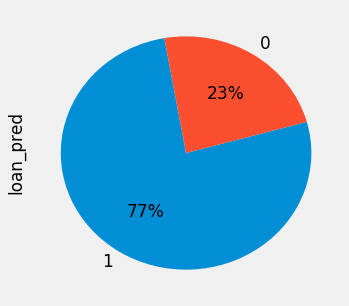

In [481]:
from matplotlib import pyplot as plt 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,5))
df['loan_pred'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

There is obvious class imbalance but there are literatures showing Ensemble Classifiers are able to handle Class Imbalance better(But they are not immune). We will try Adaboost and Random Forest.

## Selecting Features and Cleaning the Data

In [482]:
# Drop useless features
df = df.drop(["url", "desc", "member_id","id"],axis=1)

In [483]:
df_null_count = df.isnull().sum()
df_null_count = df_null_count[df_null_count!=0]
print(df_null_count)

emp_title                                      3666
dti                                              37
mths_since_last_delinq                        25472
mths_since_last_record                        41605
revol_util                                       39
last_pymnt_d                                    573
next_pymnt_d                                  45372
mths_since_last_major_derog                   37639
annual_inc_joint                              49239
dti_joint                                     49239
verification_status_joint                     49239
mths_since_rcnt_il                             1267
il_util                                        7088
all_util                                          5
avg_cur_bal                                       2
bc_open_to_buy                                  670
bc_util                                         707
mo_sin_old_il_acct                             1267
mths_since_recent_bc                            643
mths_since_r

### emp_title

In [484]:
print(df.emp_title.value_counts().head())
print(df.emp_title.value_counts().tail())
df.emp_title.unique().shape

Manager    975
Teacher    921
Owner      486
Driver     437
Sales      406
Name: emp_title, dtype: int64
Maintence worker                         1
Non Commissioned Officer                 1
Massage Therapist and Skin specialist    1
Data Systems Administrator               1
Dustrict Manager                         1
Name: emp_title, dtype: int64


(21584,)

In [485]:
# drop since we dont have enough data
df = df.drop(["emp_title"],axis=1)

Too many categories Decision trees may overfit[???]

### dti and  dti_joint

Should merge them and also keep application type since we may have same dti but application type may differ

In [486]:
df["dti_joint"] = df["dti_joint"].fillna(0)
df["new_dti"] = df[["dti_joint","dti"]].max(axis=1)

### emp_length

In [487]:
df["emp_length"] = df["emp_length"].str.replace(r"[^0-9]","")
df["emp_length"] = df["emp_length"].apply(pd.to_numeric)
avg_emp_len = df["emp_length"].mean()
df["emp_length"] = df["emp_length"].fillna(int(avg_emp_len))
df.emp_length.unique().shape

(10,)

### revol_util

In [488]:
df["revol_util"] = df["revol_util"].str.replace(r"%","")
df["revol_util"] = df["revol_util"].apply(pd.to_numeric)
df["revol_util"] = df["revol_util"].fillna(int(df["revol_util"].mean()))
df.revol_util.unique().shape

(1053,)

### annual_inc and annual_inc_joint

In [489]:
df["annual_inc_joint"] = df["annual_inc_joint"].fillna(0)
df["new_annual_inc"] = df[["annual_inc_joint","annual_inc"]].max(axis=1)
df.new_annual_inc.unique().shape

(5360,)

### mths_since_rcnt_il

In [490]:
df["mths_since_rcnt_il"] = df["mths_since_rcnt_il"].fillna(int(df["mths_since_rcnt_il"].mean()))
df.mths_since_rcnt_il.unique().shape

(224,)

### il_util

In [491]:
df["il_util"] = df["il_util"].fillna(int(df["il_util"].mean()))
df.il_util.unique().shape

(186,)

### all_util

In [492]:
df["all_util"] = df["all_util"].fillna(int(df["all_util"].mean()))
df.all_util.unique().shape

(148,)

### avg_cur_bal

In [493]:
df["avg_cur_bal"] = df["avg_cur_bal"].fillna(int(df["avg_cur_bal"].mean()))
df.avg_cur_bal.unique().shape

(26618,)

### bc_open_to_buy 575


In [494]:
df["bc_open_to_buy"] =df["bc_open_to_buy"].fillna(int(df["bc_open_to_buy"].mean()))
df.bc_open_to_buy.unique().shape

(24185,)

### bc_util 607

In [495]:
df["bc_util"] =df["bc_util"].fillna(int(df["bc_util"].mean()))
df.bc_util.unique().shape

(1098,)

### mo_sin_old_il_acct

In [496]:
df["mo_sin_old_il_acct"] =df["mo_sin_old_il_acct"].fillna(int(df["mo_sin_old_il_acct"].mean()))
df.mo_sin_old_il_acct.unique().shape

(392,)

### mths_since_recent_bc 

In [497]:
df["mths_since_recent_bc"] = df["mths_since_recent_bc"].fillna(int(df["mths_since_recent_bc"].mean()))
df.mths_since_recent_bc.unique().shape

(304,)

### mths_since_recent_inq


In [498]:
df["mths_since_recent_inq"] =df["mths_since_recent_inq"].fillna(int(df["mths_since_recent_inq"].mean()))
df.mths_since_recent_inq.unique().shape

(26,)

### percent_bc_gt_75


In [499]:
df["percent_bc_gt_75"] =df["percent_bc_gt_75"].fillna(df["percent_bc_gt_75"].mean())
df.percent_bc_gt_75.unique().shape

(120,)

### int_rate

In [500]:
df["int_rate"] = df["int_rate"].str.replace(r"%","")
df["int_rate"] = df["int_rate"].apply(pd.to_numeric)

### Count null after filtering and drop all that has null

In [501]:
df_null_count = df.isnull().sum()
df_null_count = df_null_count[df_null_count!=0]
print(df_null_count)

dti                                              37
mths_since_last_delinq                        25472
mths_since_last_record                        41605
last_pymnt_d                                    573
next_pymnt_d                                  45372
mths_since_last_major_derog                   37639
verification_status_joint                     49239
mths_since_recent_bc_dlq                      39676
mths_since_recent_revol_delinq                34109
num_tl_120dpd_2m                               2625
revol_bal_joint                               49865
sec_app_earliest_cr_line                      49865
sec_app_inq_last_6mths                        49865
sec_app_mort_acc                              49865
sec_app_open_acc                              49865
sec_app_revol_util                            49921
sec_app_open_act_il                           49865
sec_app_num_rev_accts                         49865
sec_app_chargeoff_within_12_mths              49865
sec_app_coll

In [502]:
# now drop all the missing with axis = 1
for x in df_null_count.keys():
    df = df.drop(x,axis=1)

### Drop more features reading data dictionary and mark categorical and continuous variables

In [503]:
print(df.apply(pd.Series.nunique).to_string())

loan_amnt                      1379
funded_amnt                    1379
funded_amnt_inv                1399
term                              2
int_rate                         67
installment                   11741
grade                             7
sub_grade                        35
emp_length                       10
home_ownership                    5
annual_inc                     5149
verification_status               3
issue_d                          12
pymnt_plan                        2
purpose                          12
title                            12
zip_code                        846
addr_state                       50
delinq_2yrs                      22
earliest_cr_line                612
inq_last_6mths                    6
open_acc                         58
pub_rec                          15
revol_bal                     26808
revol_util                     1053
total_acc                       105
initial_list_status               2
out_prncp                   

In [504]:
drop = ["funded_amnt","funded_amnt_inv","annual_inc","issue_d","pymnt_plan",\
        "title","zip_code","earliest_cr_line","inq_last_6mths","initial_list_status",\
        "out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",\
        "total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",\
       "collection_recovery_fee","last_pymnt_amnt","last_credit_pull_d","collections_12_mths_ex_med",\
        "acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il",\
       "open_il_12m","open_il_24m","all_util","total_cu_tl","inq_last_12m","acc_open_past_24mths",\
        "avg_cur_bal","bc_util","chargeoff_within_12_mths","delinq_amnt",\
        "mo_sin_old_il_acct","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op",\
        "mo_sin_rcnt_tl","mths_since_recent_bc","mths_since_recent_inq","num_accts_ever_120_pd",\
        "num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_bc_tl",\
        "num_il_tl","num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0",\
        "num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_op_past_12m","pct_tl_nvr_dlq",\
       "total_il_high_credit_limit","hardship_flag","disbursement_method","debt_settlement_flag",\
        "annual_inc_joint","policy_code","addr_state","sub_grade"]

In [505]:
df = df.drop(drop,axis=1)

In [506]:
print(df.apply(pd.Series.nunique).to_string())

loan_amnt                1379
term                        2
int_rate                   67
installment             11741
grade                       7
emp_length                 10
home_ownership              5
verification_status         3
purpose                    12
delinq_2yrs                22
open_acc                   58
pub_rec                    15
revol_bal               26808
revol_util               1053
total_acc                 105
application_type            2
dti_joint                1875
mths_since_rcnt_il        224
total_bal_il            35701
il_util                   186
open_rv_12m                23
open_rv_24m                37
max_bal_bc              14930
total_rev_hi_lim         3188
inq_fi                     24
bc_open_to_buy          24185
mort_acc                   21
num_sats                   56
percent_bc_gt_75          120
pub_rec_bankruptcies        7
tax_liens                  14
tot_hi_cred_lim         44481
total_bal_ex_mort       41225
total_bc_l

Categorical variables = 5

In [507]:
categorical = ["grade","verification_status","purpose","home_ownership"]

In [508]:
for x in categorical:
    df = pd.concat([df, pd.get_dummies(df[x])], axis=1)
df = df.drop(categorical,axis = 1)

In [509]:
#"application_type"
# 0 ---> 36 months
# 1 ---> 60 months
def CreateTarget(status): 
    if status == ' 36 months':
        return 0
    else:
        return 1
    
df['term'] = df['term'].map(CreateTarget)
df['term'].value_counts()

0    39266
1    12993
Name: term, dtype: int64

In [510]:
#"application_type"
# 0 ---> Joint Application
# 1 ---> Individual Application
def CreateTarget(status): 
    if status == 'Joint App':
        return 0
    else:
        return 1
    
df['application_type'] = df['application_type'].map(CreateTarget)
df['application_type'].value_counts()

1    49323
0     2936
Name: application_type, dtype: int64

In [511]:
print(df.apply(pd.Series.nunique).to_string())

loan_amnt                1379
term                        2
int_rate                   67
installment             11741
emp_length                 10
delinq_2yrs                22
open_acc                   58
pub_rec                    15
revol_bal               26808
revol_util               1053
total_acc                 105
application_type            2
dti_joint                1875
mths_since_rcnt_il        224
total_bal_il            35701
il_util                   186
open_rv_12m                23
open_rv_24m                37
max_bal_bc              14930
total_rev_hi_lim         3188
inq_fi                     24
bc_open_to_buy          24185
mort_acc                   21
num_sats                   56
percent_bc_gt_75          120
pub_rec_bankruptcies        7
tax_liens                  14
tot_hi_cred_lim         44481
total_bal_ex_mort       41225
total_bc_limit           2081
loan_pred                   2
new_dti                  4249
new_annual_inc           5360
A         

In [512]:
#with predited variable
df.shape

(52259, 60)

In [513]:
print(df.dtypes.to_string())

loan_amnt                 int64
term                      int64
int_rate                float64
installment             float64
emp_length              float64
delinq_2yrs               int64
open_acc                  int64
pub_rec                   int64
revol_bal                 int64
revol_util              float64
total_acc                 int64
application_type          int64
dti_joint               float64
mths_since_rcnt_il      float64
total_bal_il              int64
il_util                 float64
open_rv_12m               int64
open_rv_24m               int64
max_bal_bc                int64
total_rev_hi_lim          int64
inq_fi                    int64
bc_open_to_buy          float64
mort_acc                  int64
num_sats                  int64
percent_bc_gt_75        float64
pub_rec_bankruptcies      int64
tax_liens                 int64
tot_hi_cred_lim           int64
total_bal_ex_mort         int64
total_bc_limit            int64
loan_pred                 int64
new_dti 

In [514]:
y = df.loan_pred
X = df.drop("loan_pred",axis = 1)

In [515]:
y = y.values
X = X.values

### Splitting into train and test data

In [516]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

## Random Forest

Running random forest with 15 estimators and searching depth of tree as hyperparameter from 10,20,30,40,50. Weight of class is set to inverse of their ratio in the traing test.

In [454]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits = 10, shuffle = True)
specificity_test=[]
sensitivity_test=[]
specificity_train=[]
sensitivity_train=[]
accuracy_test = []
accuracy_train = []
list_tree_depth =[10,20,30,40,50]
for x in range(0,5):
    specificity_test.append([])
    sensitivity_test.append([])
    specificity_train.append([])
    sensitivity_train.append([])
    accuracy_test.append([])
    accuracy_train.append([])
for train_index, test_index in skf.split(X_train, y_train):
    train_x, test_x = X_train[train_index], X_train[test_index]
    train_y, test_y = y_train[train_index], y_train[test_index]
    
    for i in range(0,5):
        model = RandomForestClassifier(n_estimators = 15 ,criterion = 'entropy', max_features = X.shape[1],\
                                       max_depth=list_tree_depth[i], class_weight = {1:.23,0:.77})    
        model.fit(train_x, train_y)
        y_pred = model.predict(test_x)
        score_test = confusion_matrix(test_y, y_pred,labels=[1, 0])
        y_pred = model.predict(train_x)
        score_train = confusion_matrix(train_y, y_pred,labels=[1, 0])
        # train scores
        tp, fn, fp, tn = score_train.ravel()
        specificity_train[i].append(tp/(tp+fn))
        sensitivity_train[i].append(tn/(tn+fp))
        accuracy_train[i].append((tp+tn)/(tn+tp+fn+fp))
        
        # test scores
        tp, fn, fp, tn = score_test.ravel()
        specificity_test[i].append(tp/(tp+fn))
        sensitivity_test[i].append(tn/(tn+fp))
        accuracy_test[i].append((tp+tn)/(tn+tp+fn+fp))
        
        
#         balanced_scores_test[i].append(score_test)
#         balanced_scores_train[i].append(score_train)


In [455]:
mean_specificity_train =[]
mean_specificity_test = []
mean_sensitivity_train = []
mean_sensitivity_test = []
mean_accuracy_test = []
mean_accuracy_train = []
for i in range(0,5):
    mean_specificity_train.append(sum(specificity_train[i])/10)
    mean_specificity_test.append(sum(specificity_test[i])/10)
    mean_sensitivity_train.append(sum(sensitivity_train[i])/10)
    mean_sensitivity_test.append(sum(sensitivity_test[i])/10)
    mean_accuracy_test.append(sum(accuracy_test[i])/10)
    mean_accuracy_train.append(sum(accuracy_train[i])/10)

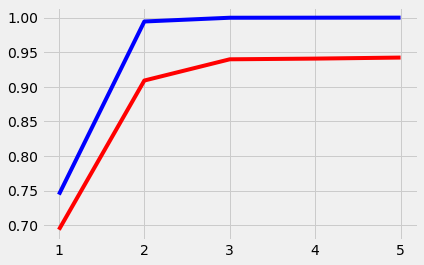

In [456]:
plt.plot(range(1,6),mean_specificity_train, color = "blue")
plt.plot(range(1,6),mean_specificity_test, color = "red")
plt.show()

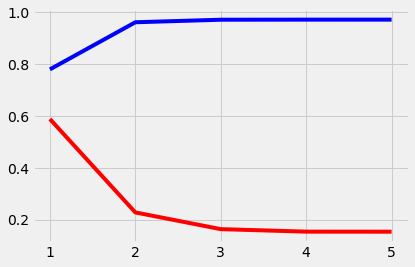

In [457]:
plt.plot(range(1,6),mean_sensitivity_train, color = "blue")
plt.plot(range(1,6),mean_sensitivity_test, color = "red")
plt.show()

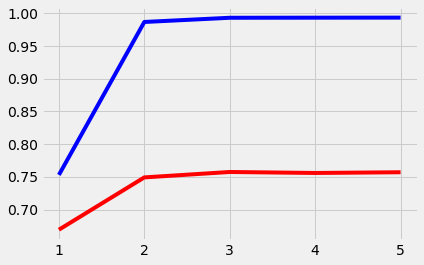

In [458]:
plt.plot(range(1,6),mean_accuracy_train, color = "blue")
plt.plot(range(1,6),mean_accuracy_test, color = "red")
plt.show()

In [523]:
model = RandomForestClassifier(n_estimators = 10 ,criterion = 'entropy', max_features = X.shape[1],max_depth=15,\
                               class_weight = {1:.23,0:.77} )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score_test = confusion_matrix(y_test, y_pred,labels=[1, 0])
y_pred = model.predict(X_train)
score_train = confusion_matrix(y_train, y_pred,labels=[1, 0])
# train scores
print("Training Scores")
tp, fn, fp, tn = score_train.ravel()
print("Specificity"+str(tp/(tp+fn)))
print("Sensitivity"+str(tn/(tn+fp)))
print("Accuracy"+str((tp+tn)/(tn+tp+fn+fp)))
        
# test scores
print("Testing Scores")
tp, fn, fp, tn = score_test.ravel()
print("Specificity"+str(tp/(tp+fn)))
print("Sensitivity"+str(tn/(tn+fp)))
print("Accuracy"+str((tp+tn)/(tn+tp+fn+fp)))
        

Training Scores
Specificity0.920732660269
Sensitivity0.892398614225
Accuracy0.914081373933
Testing Scores
Specificity0.819227403425
Sensitivity0.381573583367
Accuracy0.716513585917


In [524]:
print(score_test)

[[6553 1446]
 [1517  936]]


In [525]:
print(fp)

1446


In [461]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

# n_estimators = [100, 200, 300]
learning_rate = [0.4, 0.5, 0.6, 0.7]
skf = StratifiedKFold(n_splits = 10, shuffle = True)
specificity_test=[]
sensitivity_test=[]
specificity_train=[]
sensitivity_train=[]
accuracy_test = []
accuracy_train = []
for x in range(0,4):
    specificity_test.append([])
    sensitivity_test.append([])
    specificity_train.append([])
    sensitivity_train.append([])
    accuracy_test.append([])
    accuracy_train.append([])
for train_index, test_index in skf.split(X_train, y_train):
    train_x, test_x = X_train[train_index], X_train[test_index]
    train_y, test_y = y_train[train_index], y_train[test_index]
    

    for i in range(0,4):
        model = AdaBoostClassifier(n_estimators = 15 ,learning_rate = learning_rate[i])    
        model.fit(train_x, train_y)
        y_pred = model.predict(test_x)
        score_test = confusion_matrix(test_y, y_pred,labels=[1, 0])
        y_pred = model.predict(train_x)
        score_train = confusion_matrix(train_y, y_pred,labels=[1, 0])
        # train scores
        tp, fn, fp, tn = score_train.ravel()
        specificity_train[i].append(tp/(tp+fn))
        sensitivity_train[i].append(tn/(tn+fp))
        accuracy_train[i].append((tp+tn)/(tn+tp+fn+fp))

        # test scores
        tp, fn, fp, tn = score_test.ravel()
        specificity_test[i].append(tp/(tp+fn))
        sensitivity_test[i].append(tn/(tn+fp))
        accuracy_test[i].append((tp+tn)/(tn+tp+fn+fp))
#             balanced_scores_test[i].append(score_test)
#             balanced_scores_train[i].append(score_train)



In [462]:
mean_specificity_train =[]
mean_specificity_test = []
mean_sensitivity_train = []
mean_sensitivity_test = []
mean_accuracy_test = []
mean_accuracy_train = []
for i in range(0,4):
    mean_specificity_train.append(sum(specificity_train[i])/10)
    mean_specificity_test.append(sum(specificity_test[i])/10)
    mean_sensitivity_train.append(sum(sensitivity_train[i])/10)
    mean_sensitivity_test.append(sum(sensitivity_test[i])/10)
    mean_accuracy_test.append(sum(accuracy_test[i])/10)
    mean_accuracy_train.append(sum(accuracy_train[i])/10)

In [463]:
print(mean_specificity_train)
print(mean_sensitivity_train)
print(mean_accuracy_train)
print(mean_specificity_test)
print(mean_sensitivity_test)
print(mean_accuracy_test)

[0.99898589031144525, 0.99511697422385748, 0.99067850528535106, 0.98580592669162859]
[0.0054796943219350362, 0.024115258348551299, 0.041878855508493351, 0.057264994208148956]
[0.76576490309074852, 0.76717881066591942, 0.76795220200756487, 0.76783526003993174]
[0.9990310155517349, 0.9944989059080962, 0.98993531181619265, 0.98571552633635517]
[0.0057060732325591532, 0.02445455508012731, 0.041574124246633072, 0.05441276306856755]
[0.76585261873278787, 0.76678550150952329, 0.767311657117422, 0.76709642617879648]


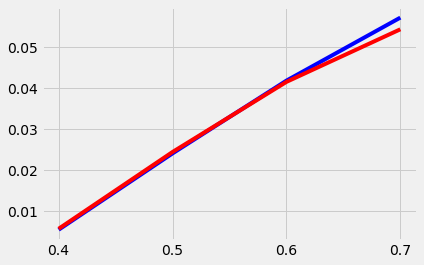

In [464]:
learning_rate = ["0.4", "0.5", "0.6", "0.7"]
x = range(1,5)
plt.xticks(x, learning_rate)
plt.plot(x,mean_sensitivity_train, color = "blue")
plt.plot(x,mean_sensitivity_test, color = "red")
plt.show()

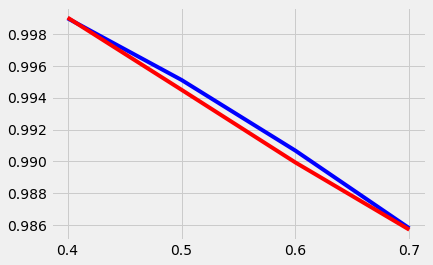

In [465]:
plt.xticks(x, learning_rate)
plt.plot(x,mean_specificity_train, color = "blue")
plt.plot(x,mean_specificity_test, color = "red")
plt.show()

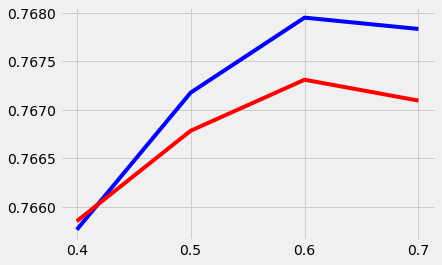

In [466]:
plt.xticks(x, learning_rate)
plt.plot(x,mean_accuracy_train, color = "blue")
plt.plot(x,mean_accuracy_test, color = "red")
plt.show()

In [527]:
model = AdaBoostClassifier(n_estimators = 15 ,learning_rate = .6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score_test = confusion_matrix(y_test, y_pred,labels=[1, 0])
y_pred = model.predict(X_train)
score_train = confusion_matrix(y_train, y_pred,labels=[1, 0])
# train scores
print("Training Scores")
tp, fn, fp, tn = score_train.ravel()
print("Specificity"+str(tp/(tp+fn)))
print("Sensitivity"+str(tn/(tn+fp)))
print("Accuracy"+str((tp+tn)/(tn+tp+fn+fp)))
        
# test scores
print("Testing Scores")
tp, fn, fp, tn = score_test.ravel()
print("Specificity"+str(tp/(tp+fn)))
print("Sensitivity"+str(tn/(tn+fp)))
print("Accuracy"+str((tp+tn)/(tn+tp+fn+fp)))

Training Scores
Specificity0.988903822711
Sensitivity0.0476869777868
Accuracy0.767957519076
Testing Scores
Specificity0.990498812352
Sensitivity0.0501426824297
Accuracy0.769804822044


In [528]:
print(score_test)

[[7923   76]
 [2330  123]]
